In [48]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [49]:
RANDOM_STATE = 42

# Read Data

In [50]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [51]:
read_query = make_read_query()

In [52]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,first_traffic_source,last_traffic_source,created_at,first_order_date,last_order_date,...,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,first_order_categories,purchased_categories,segment,churn_status
0,56219,60,F,United States,Philadelphia,Facebook,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,...,NaN,0.0,1,1.0,74.990,74.990,[Jeans],[Jeans],None,None
1,9418,69,F,United Kingdom,Cardiff,Search,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,...,630.0,0.0,2,1.0,221.500,221.500,[Intimates],"[Intimates, Outerwear & Coats]",None,None
2,21731,65,F,China,Harbin,Email,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,...,NaN,0.0,1,4.0,60.985,243.940,"[Blazers & Jackets, Maternity, Tops & Tees, Ac...","[Blazers & Jackets, Maternity, Tops & Tees, Ac...",None,None
3,39594,17,M,China,Shenzhen,Search,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,...,255.0,0.0,2,1.0,35.975,35.975,[Fashion Hoodies & Sweatshirts],"[Fashion Hoodies & Sweatshirts, Accessories]",None,None
4,2000,30,F,China,Hefei,Search,Search,2019-01-02 03:19:00,NaT,NaT,...,NaN,NaN,0,NaN,NaN,NaN,None,None,None,None


In [53]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      84011 non-null  int64         
 1   age                     84011 non-null  int64         
 2   gender                  84011 non-null  object        
 3   country                 84011 non-null  object        
 4   city                    84011 non-null  object        
 5   first_traffic_source    84011 non-null  object        
 6   last_traffic_source     84011 non-null  object        
 7   created_at              84011 non-null  datetime64[ns]
 8   first_order_date        69073 non-null  datetime64[ns]
 9   last_order_date         69073 non-null  datetime64[ns]
 10  days_to_activation      69073 non-null  float64       
 11  active_days             69073 non-null  float64       
 12  inactive_days           0 non-null      object

In [54]:
users_enriched.describe()

,id,age,created_at,first_order_date,last_order_date,days_to_activation,active_days,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value
count,84011.000000,84011.000000,84011,69073,69073,69073.000000,69073.000000,30731.000000,69073.000000,84011.000000,69073.000000,69073.000000,69073.000000
mean,50041.146457,41.061325,2021-06-14 10:42:19.902130176,2022-07-16 08:15:15.045710592,2023-01-26 08:13:51.547237632,404.987101,193.778872,275.870945,32.532509,1.490591,1.498907,59.255161,86.006317
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.490000,0.490000
25%,24998.500000,26.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 07:17:34,93.000000,0.000000,83.000000,0.000000,1.000000,1.000000,30.245000,36.083333
50%,50084.000000,41.000000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 08:41:08,284.000000,0.000000,197.000000,0.000000,1.000000,1.000000,47.432500,64.240000
75%,75057.500000,56.000000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-08 10:31:21,617.000000,269.000000,379.000000,0.000000,2.000000,2.000000,70.982500,109.231429
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1784.000000,1744.000000,1101.000000,40.000000,4.000000,999.000000,1341.490000
std,28883.727121,17.034552,NaN,NaN,NaN,386.041580,334.320750,268.147382,97.142237,1.363647,0.743731,50.940926,79.785017


# Data Preparation

In [105]:
def split_customers(users_enriched):
    inactive_users = users_enriched.loc[users_enriched.n_orders==0]
    one_off_customers = users_enriched.loc[users_enriched.n_orders==1]
    repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1]
    return repeat_purchasers, one_off_customers, inactive_users

In [106]:
def get_lifetime_cols(users_enriched, now=None):
    now = now if now else dt.datetime.now()
    users_enriched = users_enriched.copy()
    users_enriched['inactive_days'] = (now - users_enriched.last_order_date).dt.days
    users_enriched = users_enriched[['active_days', 'inactive_days', 'avg_days_to_order', 'std_days_to_order', 'avg_order_items', 'avg_item_value', 'avg_order_value']]
    return users_enriched

In [107]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

In [108]:
repeat_purchasers, one_off_customers, inactive_users = split_customers(users_enriched)
print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 30731 One-Off Customers 38342 Inactive Users 14938


In [109]:
now = users_enriched.last_order_date.max()
now

Timestamp('2024-01-21 12:55:19.720387')

In [110]:
rp_lifetime = get_lifetime_cols(repeat_purchasers, now)

In [111]:
rp_lifetime.describe()

,active_days,inactive_days,avg_days_to_order,std_days_to_order,avg_order_items,avg_item_value,avg_order_value
count,30731.000000,30731.000000,30731.000000,30731.000000,30731.000000,30731.000000,30731.000000
mean,435.550031,245.647229,275.870945,73.122189,1.560867,59.684197,86.637559
std,381.994811,270.450895,268.147382,135.065279,0.651237,37.150316,59.879672
min,0.000000,0.000000,0.000000,0.000000,1.000000,4.470000,4.470000
25%,118.000000,47.000000,83.000000,0.000000,1.000000,36.790000,46.740000
50%,332.000000,146.000000,197.000000,0.000000,1.000000,51.460000,72.645000
75%,672.000000,354.000000,379.000000,99.000000,2.000000,71.968750,109.145833
max,1784.000000,1802.000000,1744.000000,1101.000000,4.000000,745.000000,869.485000


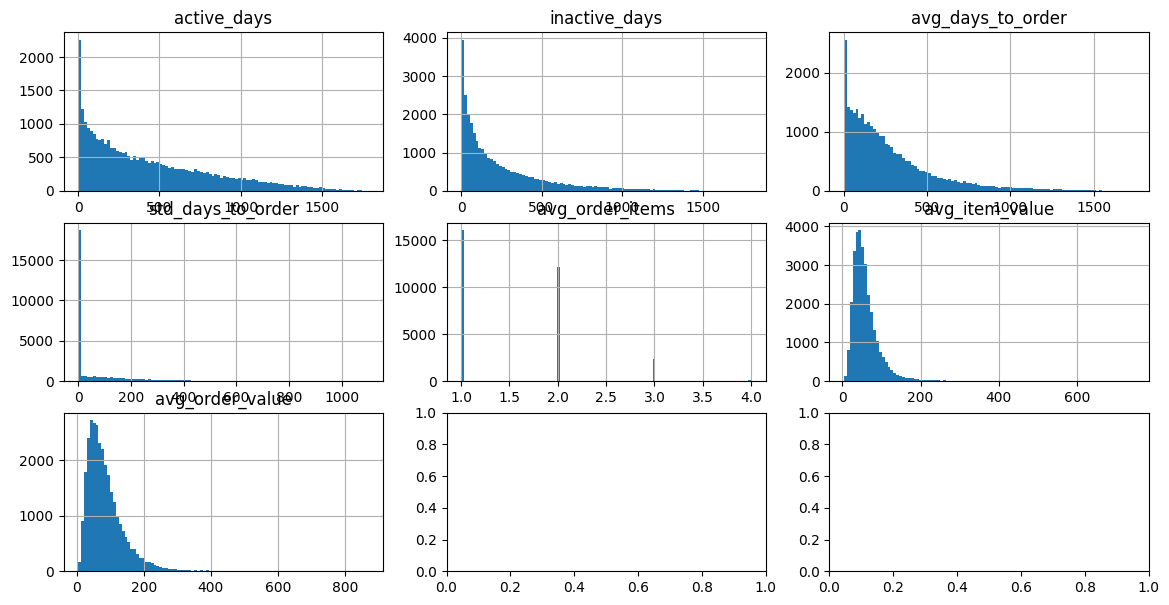

In [112]:
plot_histograms(rp_lifetime, bins=100)

<Axes: >

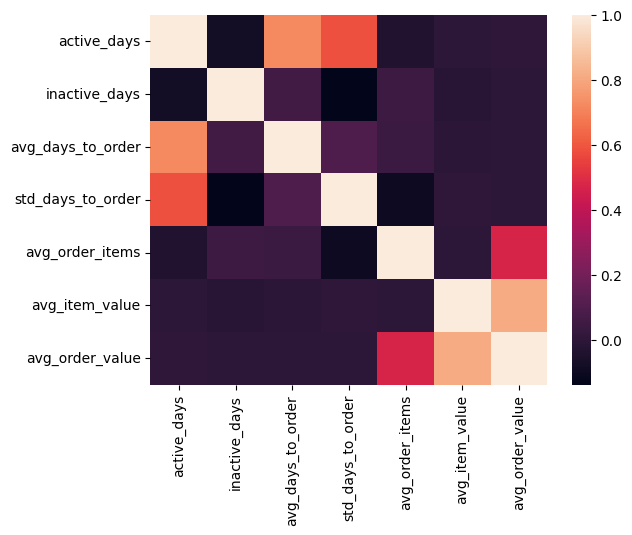

In [113]:
sns.heatmap(rp_lifetime.corr())

# Clustering Repeat Purchasers

In [114]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []        
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)
        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia if inertia else cost
        }
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [115]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [85]:
X_cols = ['active_days', 'avg_days_to_order', 'avg_order_items', 'avg_item_value']
X_raw = rp_lifetime[X_cols]

In [86]:
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

In [88]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
results = search_clustering_hyperparams(KMeans, hyperparams, X, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.32758751406812714 | Inertia: 86341.7350351058
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.3120242403254897 | Inertia: 67999.08616459862
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.3308896205578145 | Inertia: 55352.04749553371
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.32391763800529616 | Inertia: 48027.515292827076
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.32495301395811144 | Inertia: 43540.7927272549
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.3384720759364662 | Inertia: 38604.77562362588
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.29934586568871163 | Inertia: 37199.26278450468
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.2841222358390134 | Inertia: 35457.7157116009
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.2924907959904351 | Inertia: 31868.59570727708
{'n_clusters': 11, 'random_state': 42} | Si

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

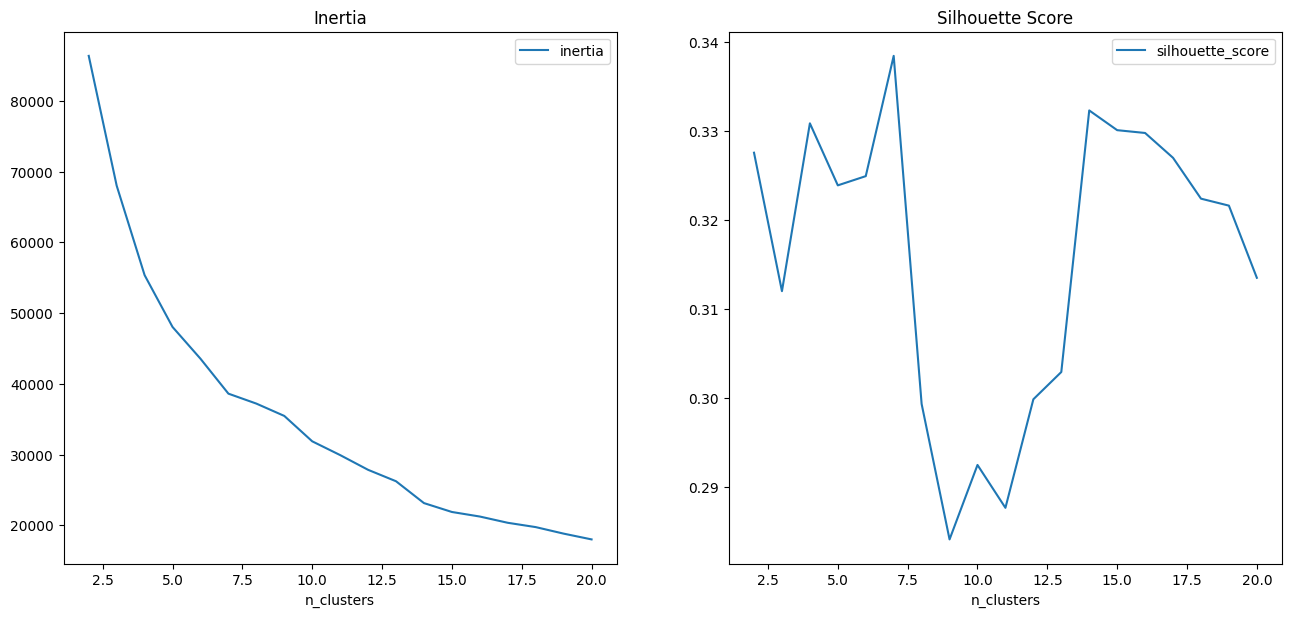

In [89]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [90]:
model = results.loc[results.n_clusters==7, 'model'].iloc[0]
rp_lifetime_segments = rp_lifetime.copy()
rp_lifetime_segments['segment'] = model.labels_

In [91]:
cluster_centers = scaler.inverse_transform(model.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=X_cols)
cluster_centers

,active_days,avg_days_to_order,avg_order_items,avg_item_value
0,796.644378,403.158806,1.000000,53.792138
1,186.657800,124.774180,2.000000,54.132691
2,310.107728,223.435597,1.335480,163.465401
3,186.482635,122.833968,1.000000,50.029059
4,206.673740,185.998939,3.070027,57.509765
5,789.046753,418.342008,2.087517,56.748772
6,1079.257780,1008.174793,1.581950,56.455587


In [92]:
rp_lifetime_segments['segment'].value_counts()

segment
3    8927
1    6924
0    5025
5    4338
6    1926
4    1884
2    1707
Name: count, dtype: int64

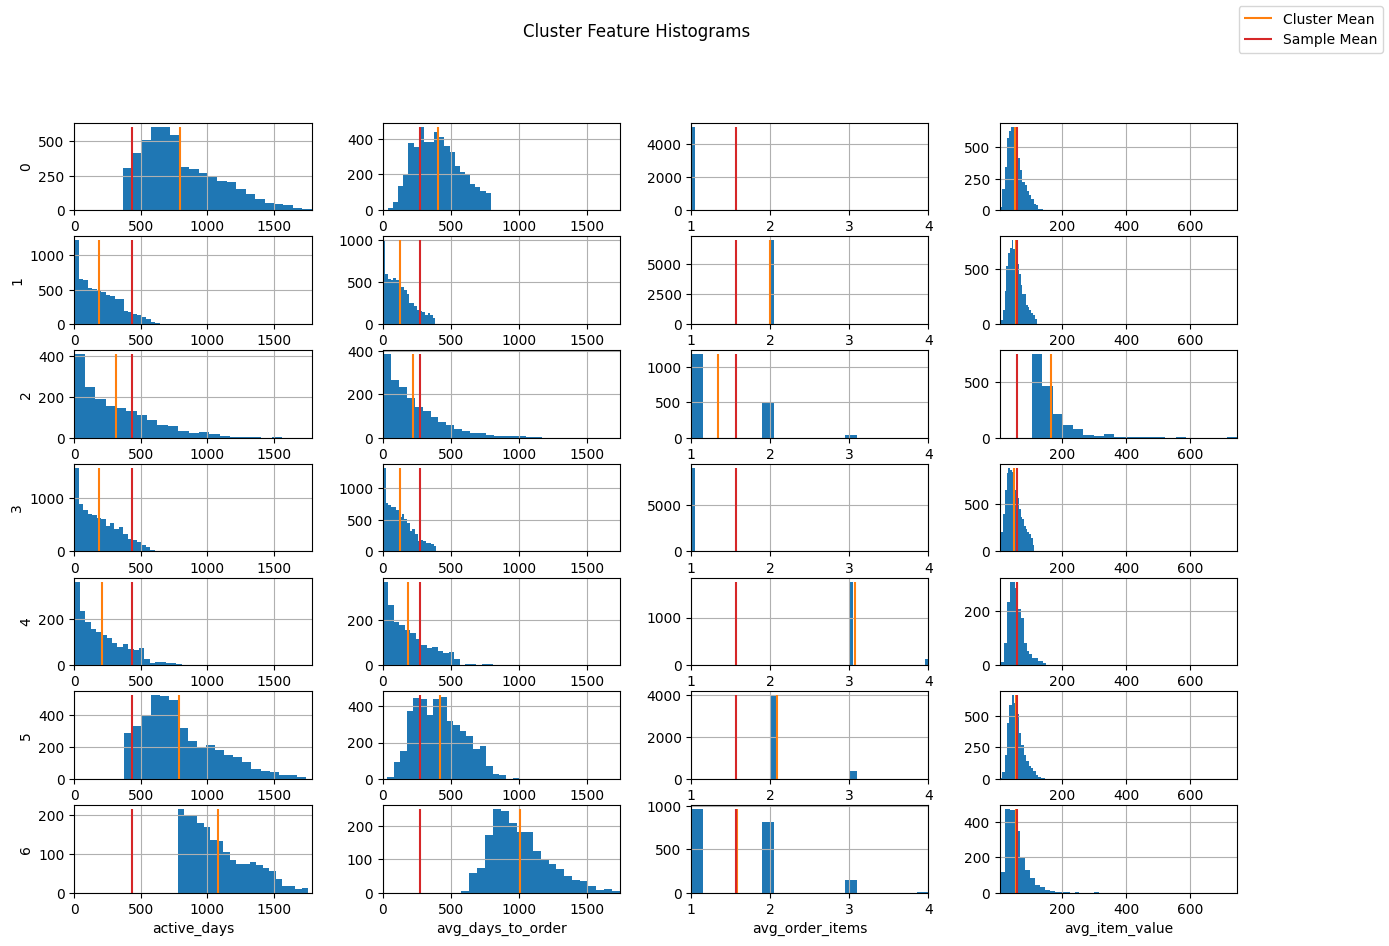

In [93]:
plot_clusters(X_raw, model.labels_)

In [94]:
print('Cluster Mean / Sample Mean:', rp_lifetime_segments.groupby('segment').mean() / rp_lifetime_segments.drop(columns='segment').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', rp_lifetime_segments.groupby('segment').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', rp_lifetime_segments.groupby('segment').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', rp_lifetime_segments.groupby('segment').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', rp_lifetime_segments.groupby('segment').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  avg_days_to_order  avg_order_items  \
segment                                                                   
0           1.829054       0.936304           1.461404         0.640670   
1           0.429308       1.012669           0.452720         1.281339   
2           0.712073       1.062194           0.809874         0.855727   
3           0.428170       0.991698           0.445310         0.640670   
4           0.474099       1.222378           0.673532         1.966897   
5           1.812974       0.993758           1.517995         1.337608   
6           2.477575       0.900526           3.655804         1.013229   

         avg_item_value  avg_order_value  
segment                                   
0              0.901279         0.690134  
1              0.907322         1.069710  
2              2.739393         2.379282  
3              0.838337         0.615888  
4              0.963512         1.7908

In [95]:
segment_map = {
    0: 'Loyal Single-Item Orderers',
    1: 'Multi-Item Orderers',
    2: 'High Value Item Orderers',
    3: 'Single-Item Orderers',
    4: 'Multi-Item Orderers',
    5: 'Loyal Multi-Item Orderers',
    6: 'Loyals with Low Frequency',
}

In [96]:
rp_lifetime_segments['segment'] = rp_lifetime_segments['segment'].map(segment_map) 

In [97]:
rp_lifetime_segments

,active_days,inactive_days,avg_days_to_order,avg_order_items,avg_item_value,avg_order_value,segment
1,630.0,274,630.0,1.0,221.500000,221.500000,High Value Item Orderers
3,255.0,1549,255.0,1.0,35.975000,35.975000,Single-Item Orderers
5,1264.0,7,252.0,2.0,58.932222,88.398333,Loyal Multi-Item Orderers
8,283.0,384,94.0,1.0,29.812000,37.265000,Single-Item Orderers
10,584.0,1243,292.0,1.0,25.817500,34.423333,Loyal Single-Item Orderers
...,...,...,...,...,...,...,...
83994,0.0,3,0.0,2.0,78.111429,136.695000,Multi-Item Orderers
83996,0.0,2,0.0,2.0,43.077500,86.155000,Multi-Item Orderers
84003,0.0,3,0.0,2.0,107.663333,161.495000,Multi-Item Orderers
84004,0.0,3,0.0,1.0,82.555000,82.555000,Single-Item Orderers


In [99]:
rp_lifetime_segments.segment.value_counts()

segment
Single-Item Orderers          8927
Multi-Item Orderers           8808
Loyal Single-Item Orderers    5025
Loyal Multi-Item Orderers     4338
Loyals with Low Frequency     1926
High Value Item Orderers      1707
Name: count, dtype: int64

In [102]:
segment_cltv = rp_lifetime_segments.groupby('segment')[['active_days', 'avg_days_to_order', 'avg_order_value']].mean()
segment_cltv['cltv'] = (segment_cltv['active_days'] / segment_cltv['avg_days_to_order']) * segment_cltv['avg_order_value']
segment_cltv

,active_days,avg_days_to_order,avg_order_value,cltv
segment,,,,
High Value Item Orderers,310.143527,223.420621,206.135170,286.148558
Loyal Multi-Item Orderers,789.640848,418.770632,102.714382,193.679941
Loyal Single-Item Orderers,796.644378,403.158806,59.791500,118.148386
Loyals with Low Frequency,1079.107996,1008.530114,80.068399,85.671661
Multi-Item Orderers,191.157811,137.922003,106.041222,146.971531
Single-Item Orderers,186.489638,122.848101,53.359021,81.001695


# Flag Potentially Churned Customers

In [142]:
def add_churn_status(rp_lifetime_segments, percentile=0.9):
    churn_mask = rp_lifetime_segments['inactive_days'] > (rp_lifetime_segments['avg_days_to_order'] 
                                                         + 2 * rp_lifetime_segments['std_days_to_order'])
    rp_lifetime_segments['churn_status'] = 'Active'
    rp_lifetime_segments.loc[churn_mask, 'churn_status'] = 'Churn Likely'
    return rp_lifetime_segments

In [143]:
rp_lifetime_flagged = add_churn_status(rp_lifetime_segments)

In [144]:
rp_lifetime_flagged.groupby('segment')['churn_status'].value_counts()

segment                     churn_status
High Value Item Orderers    Active           938
                            Churn Likely     769
Loyal Multi-Item Orderers   Active          3868
                            Churn Likely     470
Loyal Single-Item Orderers  Active          4539
                            Churn Likely     486
Loyals with Low Frequency   Active          1921
                            Churn Likely       5
Multi-Item Orderers         Churn Likely    4698
                            Active          4110
Single-Item Orderers        Churn Likely    4597
                            Active          4330
Name: count, dtype: int64

# Concat Data

In [151]:
def concat_cols(df, df_cols):
    df = df.drop(columns=df_cols.columns)
    return  pd.concat([df, df_cols], axis=1)

In [160]:
def concat_customers(repeat_purchasers_segmented, one_off_customers, inactive_users):
    one_off_customers['segment'] = 'One-Off Customers'
    inactive_users['segment'] = 'Never Ordered'
    customers_segmented = pd.concat([repeat_purchasers_segmented, one_off_customers, inactive_users])\
                            .sort_values('created_at')
    return customers_segmented

In [186]:
repeat_purchasers_segmented = concat_cols(repeat_purchasers, rp_lifetime_flagged)

oo_lifetime = get_lifetime_cols(one_off_customers, now)
one_off_customers_ = concat_cols(one_off_customers, oo_lifetime)

customers_segmented = concat_customers(repeat_purchasers_segmented, one_off_customers_, inactive_users)

/tmp/ipykernel_208715/2988918823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive_users['segment'] = 'Never Ordered'


In [187]:
customers_segmented.groupby(['segment'])['id'].count()

segment
High Value Item Orderers       1707
Loyal Multi-Item Orderers      4338
Loyal Single-Item Orderers     5025
Loyals with Low Frequency      1926
Multi-Item Orderers            8808
Never Ordered                 14938
One-Off Customers             38342
Single-Item Orderers           8927
Name: id, dtype: int64

# Save Pipeline 

In [179]:
pipe = Pipeline([('scaler', scaler), ('kmeans', model)])

In [180]:
# with open('../models/cust_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(pipe, f)

In [181]:
with open('../models/cust_segment_pipe.pkl', 'rb') as f:
    pipe_loaded = pkl.load(f)

In [182]:
y = pipe_loaded.predict(X_raw)
(y == model.labels_).all()

np.True_

In [183]:
with open('../models/cust_segment_map.json', 'w') as f:
    json.dump(segment_map, f)

In [184]:
with open('../models/cust_segment_map.json', 'r') as f:
    segment_map_ = json.load(f)

In [185]:
segment_map_

{'0': 'Loyal Single-Item Orderers',
 '1': 'Multi-Item Orderers',
 '2': 'High Value Item Orderers',
 '3': 'Single-Item Orderers',
 '4': 'Multi-Item Orderers',
 '5': 'Loyal Multi-Item Orderers',
 '6': 'Loyals with Low Frequency'}